In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [ ]:
# !pip install pandas
# !pip install matplotlib
# !pip install tqdm

In [2]:
class Stock:
    def __init__(self,symbol):
        self.symbol = symbol
        self.data = None

    def load_data(self,directory):
        file_path = os.path.join(directory,f"{self.symbol}.csv")
        if os.path.exists(file_path):
            self.data = pd.read_csv(file_path)
            self.data['Date'] = pd.to_datetime(self.data['Date'])
            self.data = self.data.set_index(self.data['Date'])
            self.data = self.data.sort_index()
        else:
            raise FileNotFoundError(f"CSV file for symbol {self.symbol} not found in directory")
            
    def trim_by_date(self, start_date,end_date):
        self.data = self.data[start_date:end_date]
            
    def get_stock_data_by_date(self,date):
        if self.data is not None:
            stock_data = self.data[self.data['Date'] == date]
            if not stock_data.empty:
                return stock_data.iloc[0].to_dict()
            else:
                return f"No data available for {self.symbol} on {date}"
        else:
            return "Data not loaded. Please load the csv file first."

In [18]:
directory = "/home/ashli/ML/data/stocks/"
symbol = "EBTC"

In [19]:
stock = Stock(symbol)
stock.load_data(directory)
stock.get_stock_data_by_date("1962-02-15")

'No data available for EBTC on 1962-02-15'

In [20]:
stock.data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2005-02-14,2005-02-14,18.50,25.200001,18.500000,20.5,14.264810,21600
2005-02-15,2005-02-15,21.25,22.000000,20.000000,20.0,13.916887,2000
2005-02-16,2005-02-16,21.00,21.000000,21.000000,21.0,14.612738,1000
2005-02-17,2005-02-17,20.50,21.500000,19.754999,20.0,13.916887,4200
2005-02-18,2005-02-18,20.00,20.059999,19.500000,19.5,13.568962,1400


In [21]:
def get_tsla_startdate(directory,sym):
    tsla = Stock(sym)
    tsla.load_data(directory)
    tsla.data['Date'] = pd.to_datetime(tsla.data['Date'])
    start_date = tsla.data['Date'].min()
    end_date = tsla.data['Date'].max()
    return start_date,end_date

In [22]:
start,end = get_tsla_startdate(directory,symbol)
print(stock.trim_by_date(start,end))

None


AttributeError: 'NoneType' object has no attribute 'head'

In [7]:
def plot_stock_data(stock):
    if stock.data is not None:
        plt.figure(figsize = (10,6))
        
        # plt.plot(stock.data['Date'], stock.data['Open'], label='Open', color='green')
        # plt.plot(stock.data['Date'], stock.data['High'], label='High', color='blue')
        # plt.plot(stock.data['Date'], stock.data['Low'], label='Low', color='red')
        plt.plot(stock.data['Date'], stock.data['Close'], label='Close', color='orange')

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f"Stock price for {stock.symbol}")
        plt.legend()
        plt.grid(True)

        plt.show()
    else:
        print("Data not loaded. Please load the csv file first.")

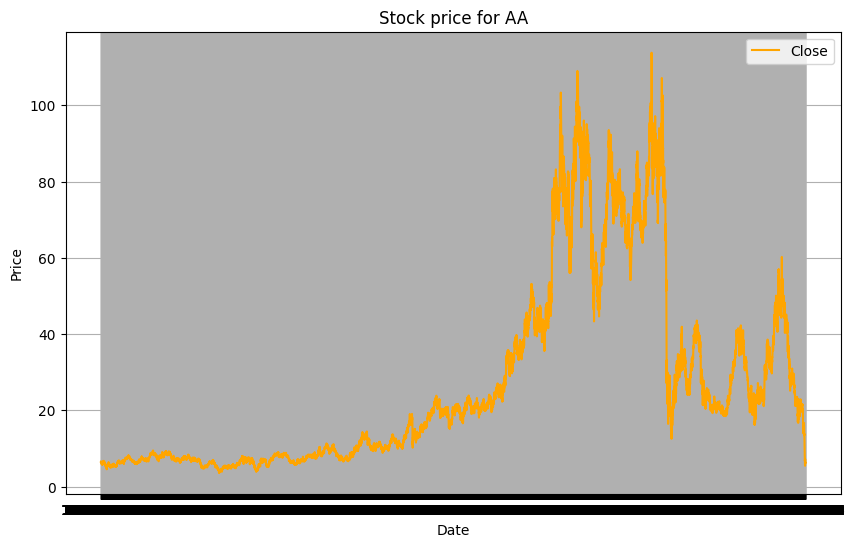

In [8]:
plot_stock_data(stock)

In [9]:
def moving_avg(stock,period):
    if stock.data is not None:
        df = pd.DataFrame(stock.data, columns=['Close'])
        df['SMA'] = df['Close'].rolling(window=period).mean()
        return df

In [10]:
moving_avg(stock,3)

,Close,SMA
0,6.532155,NaN
1,6.632280,NaN
2,6.632280,6.598905
3,6.624270,6.629610
4,6.408000,6.554850
...,...,...
14658,6.840000,7.066667
14659,6.550000,6.826667
14660,6.070000,6.486667
14661,6.160000,6.260000


In [11]:
moving_avg(stock,10)

,Close,SMA
0,6.532155,NaN
1,6.632280,NaN
2,6.632280,NaN
3,6.624270,NaN
4,6.408000,NaN
...,...,...
14658,6.840000,6.575
14659,6.550000,6.430
14660,6.070000,6.355
14661,6.160000,6.271


In [12]:
moving_avg(stock,20)

,Close,SMA
0,6.532155,NaN
1,6.632280,NaN
2,6.632280,NaN
3,6.624270,NaN
4,6.408000,NaN
...,...,...
14658,6.840000,8.8365
14659,6.550000,8.4705
14660,6.070000,8.0875
14661,6.160000,7.7485


In [13]:
max(stock.data['Close'].values)

np.float64(113.78205108642578)

In [14]:
def max_profit(stock,initial_cap,max_trade):
    j = initial_cap
    stock_held = 0
    trades_done = 0
    max_trade_allowed = max_trade // 2
    prices = pd.DataFrame(stock.data, columns=['Close']).values
    for i in range(1 ,len(prices)):
        #buy stock at a dip
        if prices[i] < prices[i-1] and trades_done < max_trade_allowed and capital >= prices[i]:
            stocks_to_buy = capital // prices[i]
            capital -= stocks_to_buy * prices[i]
            stock_held += stocks_to_buy
            trades_done += 1
        #sell stock at high
        elif prices[i] > prices[i-1] and stock_held > 0:
            capital += stock_held * prices[i]
            stock_held = 0
            trades_done +=1
        if trades_done >= max_trade:
            break
    if stock_held > 0:
        capital += stocks_held * prices[-1]

    return capital

            

In [15]:
def max_profit_naive(stock, capital=1000, max_trade=10):
    min_index = stock.data['Close'].idxmin()
    max_index = stock.data['Close'].idxmax()
    quantity = 0
    if max_index>min_index:
        buy_price = float(stock.data["Close"][min_index])
        quantity += capital//buy_price
        capital -= quantity*buy_price

        sell_price = float(stock.data["Close"][max_index])
        capital += quantity*sell_price
        quantity = 0
    return capital

In [16]:
initial_capital = 1000
trade_capital = max_profit_naive(stock,initial_capital)
print("Profit: {}, {}%".format(trade_capital, (trade_capital/initial_capital)*100))

Profit: 31065.35106778145, 3106.535106778145%


In [17]:
def max_corelation_tesla(directory,stock_symbol,tesla_sym="TSLA"):
    tesla = Stock(tesla_sym)
    tesla.load_data(directory)
    if tesla.data is None:
        print("Tesla data is not loaded")
    tesla.data['Date'] = pd.to_datetime(tesla.data['Date'])
    tesla.data = tesla.data.sort_values('Date')
    tesla_closing_price = tesla.data['Close']
    max_corelation = -1
    max_corelation_stock = None
    for symbol in stock_symbol:
        stock = Stock(symbol)
        try:
            stock.load_data(directory)
            stock.data['Date'] = pd.to_datetime(stock.data['Date'])
            stock.data = stock.data.sort_values('Date')
            merge_data = pd.merge(tesla.data[['Date','Close']],stock.data[['Date','Close']], on='Date',suffixes=('_tesla',f'_{symbol}'))
            correlation = merge_data['Close_tesla'].corr(merge_data[f'Close_{symbol}'])
            if correlation > max_corelation:
                max_corelation = correlation
                max_corelation_stock = symbol
        except FileNotFoundError as e:
            print(e)

    return max_corelation_stock,max_corelation

In [18]:
directory = "/home/ashli/ML/data/stocks/"
stock_symbol = ['AA','A','AAMC','AFT','AKTS','ALRN','AMEH','CORE','CRIS','TWIN','THBRU']

In [20]:
max_corr_stock,max_corr = max_corelation_tesla(directory,stock_symbol)

In [21]:
max_corr_stock

'THBRU'

In [22]:
max_corr

np.float64(0.8666932984039588)

In [23]:
tesla = Stock(symbol="TSLA")
thbru = Stock(symbol="THBRU")
tesla.load_data(directory)
thbru_data = thbru.load_data(directory)

In [154]:
def plot_graph():
    tesla = Stock(symbol="TSLA")
    thbru = Stock(symbol="AER")
    tesla.load_data(directory)
    thbru.load_data(directory)
    plt.figure(figsize=(10,6))
    plt.plot(tesla.data['Date'], tesla.data['Close'], label='tesla', color='red')
    plt.plot(thbru.data['Date'], thbru.data['Close'], label='thbru', color='green')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


    

    

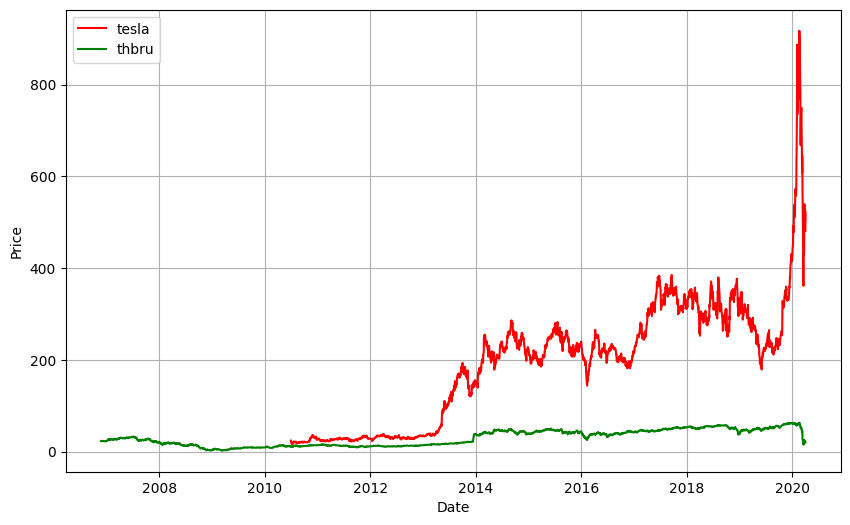

In [155]:
plot_graph()

In [62]:
def get_stocks(directory):
    stocks_before_2010 = []
    for filename in tqdm(os.listdir(directory)):
        file_path = os.path.join(directory,filename)
        if not file_path.endswith(".csv"): continue
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        start_date = df['Date'].min()
        if start_date.year < 2010:
            stocks_before_2010.append(filename.split('.')[0])
    return stocks_before_2010

In [63]:
stocks_before_2010 = get_stocks(directory)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5885/5885 [00:47<00:00, 123.94it/s]


In [85]:
stocks_before_2010 = random.sample(stocks_before_2010,30)

In [138]:
start,end = get_tsla_startdate(directory)

In [139]:
print(start,end)

2010-06-29 00:00:00 2020-04-01 00:00:00


In [86]:
len(stocks_before_2010)

30

In [141]:
def divide_data(directory):
    stock_list = []
    tsla_start_date,tsla_end_date = get_tsla_startdate(directory)
    for stock_name in tqdm(stocks_before_2010):
        stock_obj = Stock(stock_name)
        stock_obj.load_data(directory)
        stock_obj.trim_by_date(tsla_start_date,tsla_end_date)
        stock_list.append(stock_obj)
    return stock_list

In [142]:
stock_list = divide_data(directory)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.43it/s]


In [175]:
len(stock_list[28].data),len(tesla.data)

(1725, 2457)

In [146]:
def find_corr(stock_a,stock_b):
    return stock_a.data['Close'].corr(stock_b.data['Close'])

In [147]:
find_corr(stock_list[3],tesla)

nan

In [148]:
print(tesla.data['Close'].nunique())
print(stock_list[0].data['Close'].nunique())

2266
1744


In [149]:
stock_correlations = []
for candidate_stock in stock_list:
    arr1 = np.array(list(tesla.data["Close"]))
    arr2 = np.array(list(candidate_stock.data["Close"]))
    if len(arr1)!=len(arr2):
        print("Invalid lengths",len(arr1),len(arr2))
        continue
    corr_value = np.corrcoef(arr1,arr2)[0][1]
    stock_correlations.append((candidate_stock,corr_value))

Invalid lengths 2457 2378
Invalid lengths 2457 1725
Invalid lengths 2457 2458


In [150]:
stock_correlations = sorted(stock_correlations, key=lambda x: -x[1])

In [152]:
stock_correlations[1][0].symbol

'ECL'

In [153]:
tesla.data['Close'].corr(stock_list[0].data['Open'])

nan

In [131]:
[(_a.symbol, _b) for _a, _b in stock_correlations]

[('AER', np.float64(0.8602317657402482)),
 ('ECL', np.float64(0.8398009365296758)),
 ('DSGX', np.float64(0.8294571157992481)),
 ('KAI', np.float64(0.8195555400601534)),
 ('BXS', np.float64(0.8185747109909907)),
 ('BRO', np.float64(0.8049002846876478)),
 ('DGX', np.float64(0.7883540491733518)),
 ('EBTC', np.float64(0.7868488985059017)),
 ('TREX', np.float64(0.7868289995408201)),
 ('OVLY', np.float64(0.7734796272463507)),
 ('AIMC', np.float64(0.6999171765590372)),
 ('WLFC', np.float64(0.6786570419585178)),
 ('BBSI', np.float64(0.6580141787640622)),
 ('PLT', np.float64(0.2785930966830737)),
 ('GPX', np.float64(0.2495575374318846)),
 ('GJH', np.float64(0.21991819796714154)),
 ('RWT', np.float64(0.19165932879851144)),
 ('KTCC', np.float64(-0.07666436539393794)),
 ('DKS', np.float64(-0.11800362868284338)),
 ('HLIT', np.float64(-0.14293213853776437)),
 ('NUM', np.float64(-0.371537206136879)),
 ('JJC', np.float64(-0.42793729381061774)),
 ('BWEN', np.float64(-0.4716215525946348)),
 ('SEED', np.

In [ ]:
def max_min_correlation(directory,sym='TSLA'):
    stock_data = devide_data(directory)
    tesla = Stock(sym)
    tesla.load_data(directory)
    tesla.data['Date'] = pd.to_datetime(tesla.data['Date'])
    tesla.data = tesla.data.sort_values('Date')
    tesla_closing_price = tesla.data['Close']
    max_corelation = -1
    max_corelation_stock = None
    min_corelation = 1
    min_corelation_stock = None
    for stock in stock_data:
        
        